In [1]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# make necessary imports
import zipline
from zipline.api import (order_target_percent, symbol,
                         set_commission, set_slippage, 
                         schedule_function, date_rules, time_rules)
from zipline.finance.commission import PerDollar
from datetime import datetime
import pytz
from matplotlib import pyplot as plt
import pandas as pd
import pyfolio as pf
from trading_calendars import get_calendar
import seaborn as sns
import zipline
from os import listdir
idx = pd.IndexSlice

In [3]:
# path to data files
path = 'data'

In [4]:
# get the names of all .csv files in data folder
symbols = [f[:-4] for f in listdir(path)]

In [5]:
# list symbols
symbols

['BSE-100', 'MF103178', 'MF113047', 'QNIFTY']

In [6]:
# read .csv files and build a pandas datafame
def get(tickers): 
    def data(ticker):
        print('Processing...', ticker)
        return pd.read_csv('{}/{}.csv'.format(path, ticker), index_col=[0], parse_dates=[0])
    datas = map(data, tickers)
    return(pd.concat(datas, keys=tickers, names=['ticker', 'date']))
               
symbols_df = get(symbols)

Processing... BSE-100
Processing... MF103178
Processing... MF113047
Processing... QNIFTY


In [7]:
# check the datafram head
symbols_df.head(2)

open         high          low        close  \
ticker  date                                                             
BSE-100 2007-09-17  8089.669922  8128.069824  8008.700195  8036.970215   
        2007-09-18  8055.919922  8135.350098  8021.290039  8125.430176   

                        volume  dividend  split  
ticker  date                                     
BSE-100 2007-09-17  35033300.0         0      0  
        2007-09-18  38019700.0         0      0

In [8]:
# unstack the dataframe to get close prices
symbols_prices = symbols_df.unstack('ticker')['close'].asfreq('D', method='ffill').dropna()

In [9]:
# quick verification of dataframe head and tail
symbols_prices.head(2).append(symbols_prices.tail(2))

ticker,BSE-100,MF103178,MF113047,QNIFTY
date,,,,
2010-06-28,9480.250000,34.4939,10.0063,529.05
2010-06-29,9361.290039,34.5101,10.0080,526.25
2020-06-08,10273.120117,80.7084,23.1256,1050.00
2020-06-09,10162.700195,80.7861,23.1426,1033.28


In [10]:
# rebase the data 
symbols_prices = symbols_prices/symbols_prices.iloc[0]
symbols_prices.head(2).append(symbols_prices.tail(2))

ticker,BSE-100,MF103178,MF113047,QNIFTY
date,,,,
2010-06-28,1.000000,1.000000,1.000000,1.000000
2010-06-29,0.987452,1.000470,1.000170,0.994707
2020-06-08,1.083634,2.339788,2.311104,1.984690
2020-06-09,1.071987,2.342040,2.312803,1.953086


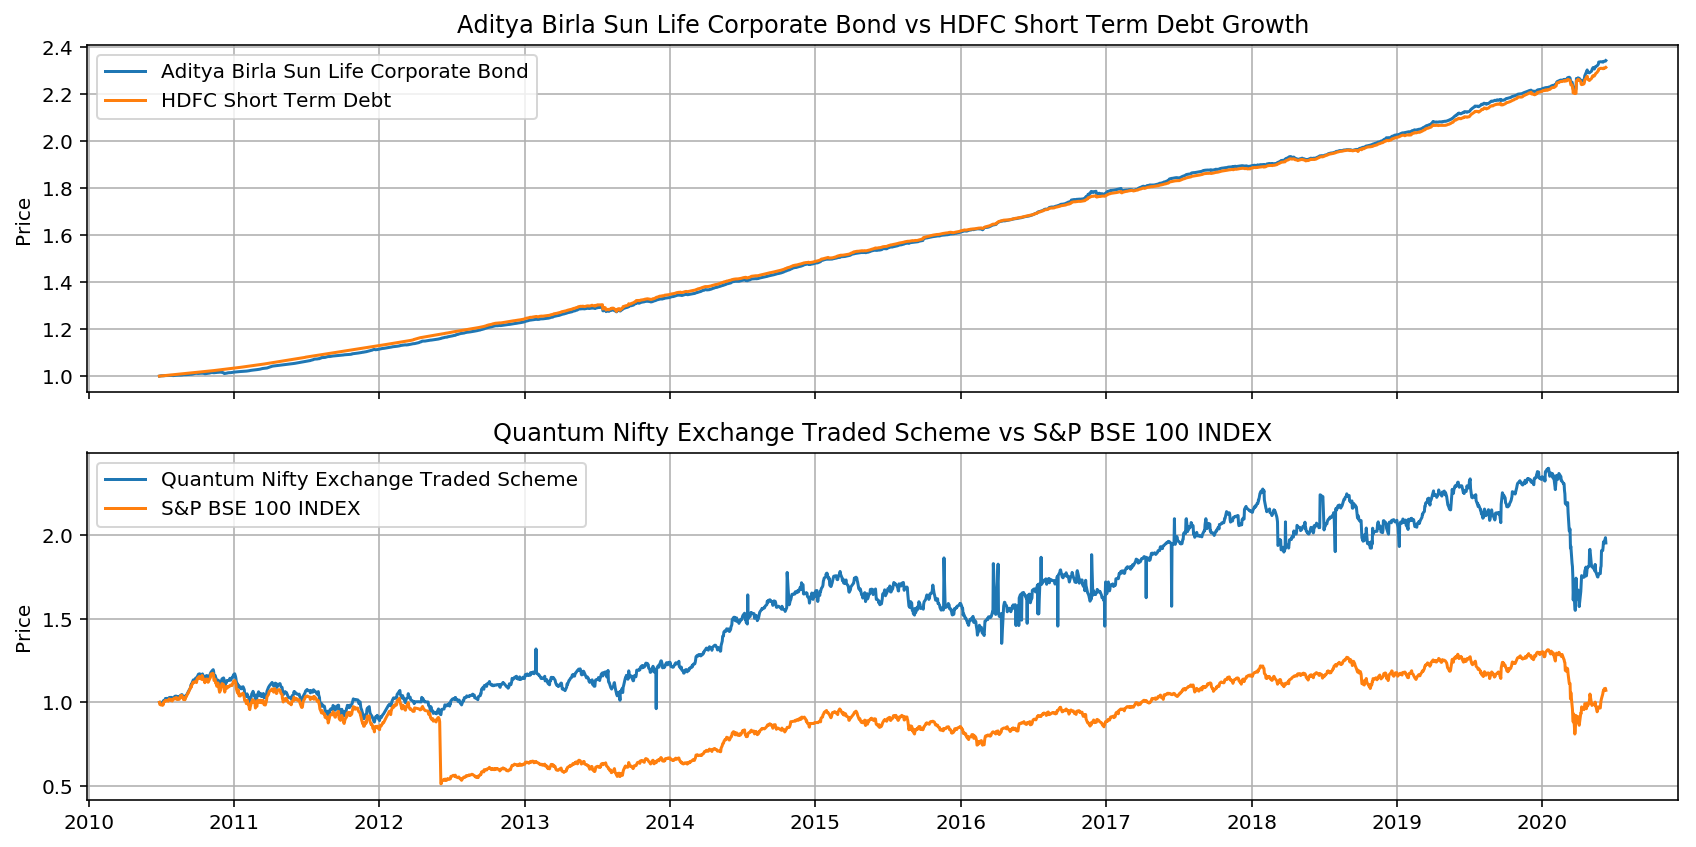

In [11]:
# visulize the date for a quick comparision
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(symbols_prices['MF103178'], label = 'Aditya Birla Sun Life Corporate Bond')
ax[0].plot(symbols_prices['MF113047'], label = 'HDFC Short Term Debt')
ax[0].set(title = 'Aditya Birla Sun Life Corporate Bond vs HDFC Short Term Debt Growth', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(symbols_prices['QNIFTY'], label = 'Quantum Nifty Exchange Traded Scheme')
ax[1].plot(symbols_prices['BSE-100'], label = 'S&P BSE 100 INDEX')
ax[1].set(title = 'Quantum Nifty Exchange Traded Scheme vs S&P BSE 100 INDEX', ylabel = 'Price')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
plt.savefig('chart1', dpi=600)

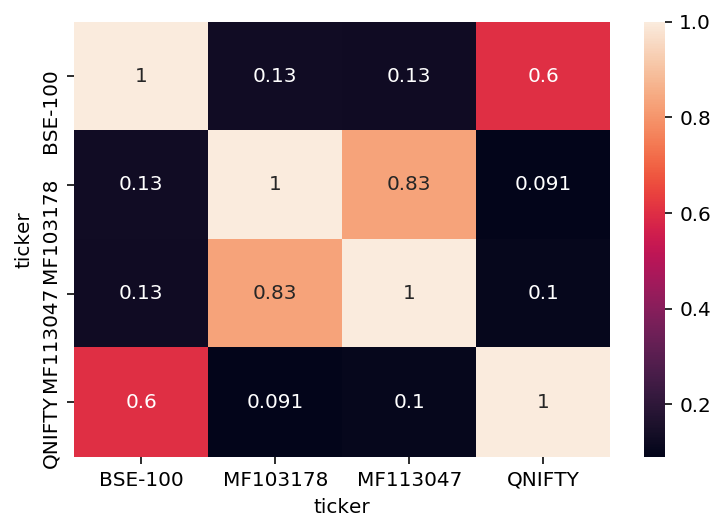

In [12]:
# visulize debt funds corelation with equity
fig = sns.heatmap(symbols_prices.pct_change().corr(method ='spearman'), annot=True)
plt.savefig('chart2', dpi=300)  

In [13]:
#Commission and Slippage Settings
enable_commission = True
commission_pct = 0.004 # 0.4% commission on buy/ sell

In [14]:
def initialize(context):

    # Set commission
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    
    # counter for rebalance quarterly
    context.counter = 0
    
    # Securities and target weights
    context.securities = {'QNIFTY': 0.6,      # Quantum Nifty Exchange Traded Scheme
                          'MF103178' : 0.2,  # Aditya Birla Sun Life Corporate Bond Fund
                          'MF113047' : 0.2}  # HDFC Short Term Debt Growth
                          
    schedule_function(rebalance_freq, 
                      date_rules.month_start(), 
                      time_rules.market_open())

In [15]:
# rebalance once a year only
def rebalance_freq(context, data):  
    freq_month = 12  
    context.counter += 1  
    if context.counter == freq_month:  
        rebalance(context, data)  
        context.counter = 0 

In [16]:
# rebalance order percentages
def rebalance(context, data):
    # Loop through the securities
    for sec, weight in context.securities.items():
        sym = symbol(sec)
        # Check if we can trade
        if data.can_trade(sym):
            # Reset the weight
            order_target_percent(sym, weight)
            print('today...',zipline.api.get_datetime().date())

In [17]:
# start = pd.Timestamp('2011-01-01',).tz_localize('utc') 
start = pd.Timestamp('2011-01-01',).tz_localize('utc')
end = pd.Timestamp('2020-06-09', ).tz_localize('utc') 

In [18]:
# Fire the backtest
result = zipline.run_algorithm(
    start=start, # Set start
    end=end,  # Set end
    analyze=None, 
    initialize=initialize, # Define startup function
    capital_base=200000, # Set initial capital
    data_frequency = 'daily',  # Set data frequency
    bundle= 'nse_data') 

C:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


today... 2011-12-01
today... 2011-12-01
today... 2011-12-01
today... 2012-12-03
today... 2012-12-03
today... 2012-12-03
today... 2013-12-02
today... 2013-12-02
today... 2013-12-02
today... 2014-12-01
today... 2014-12-01
today... 2014-12-01
today... 2015-12-01
today... 2015-12-01
today... 2015-12-01
today... 2016-12-01
today... 2016-12-01
today... 2016-12-01
today... 2017-12-01
today... 2017-12-01
today... 2017-12-01
today... 2018-12-03
today... 2018-12-03
today... 2018-12-03
today... 2019-12-02
today... 2019-12-02
today... 2019-12-02


In [19]:
# extract the inputs needed for pyfolio
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)

In [20]:
# returns for the strategy
returns.name = 'Strategy'
returns.head(2)

2011-01-03 00:00:00+00:00    0.0
2011-01-04 00:00:00+00:00    0.0
Name: Strategy, dtype: float64

In [21]:
# get the benchmark returns
benchmark_rets = symbols_prices['BSE-100'].pct_change().dropna()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC')
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'S&P BSE-100'
benchmark_rets.head(2)

date
2011-01-03 00:00:00+00:00    0.003767
2011-01-04 00:00:00+00:00   -0.002776
Name: S&P BSE-100, dtype: float64

Start date,2011-01-03
End date,2020-06-09
Total months,113
,Backtest
Annual return,5.2%
Cumulative returns,60.5%
Annual volatility,20.7%
Sharpe ratio,0.35
Calmar ratio,0.24
Stability,0.91
Max drawdown,-21.5%


C:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.53,2020-01-17,2020-03-24,NaT,NaN
1,17.27,2015-11-20,2016-04-13,2016-07-21,175
2,17.21,2013-01-29,2013-11-27,2014-04-02,307
3,14.42,2016-11-25,2016-12-28,2017-04-24,107
4,14.02,2016-07-21,2016-09-01,2016-11-25,92


C:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\pyfolio\plotting.py:784: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()


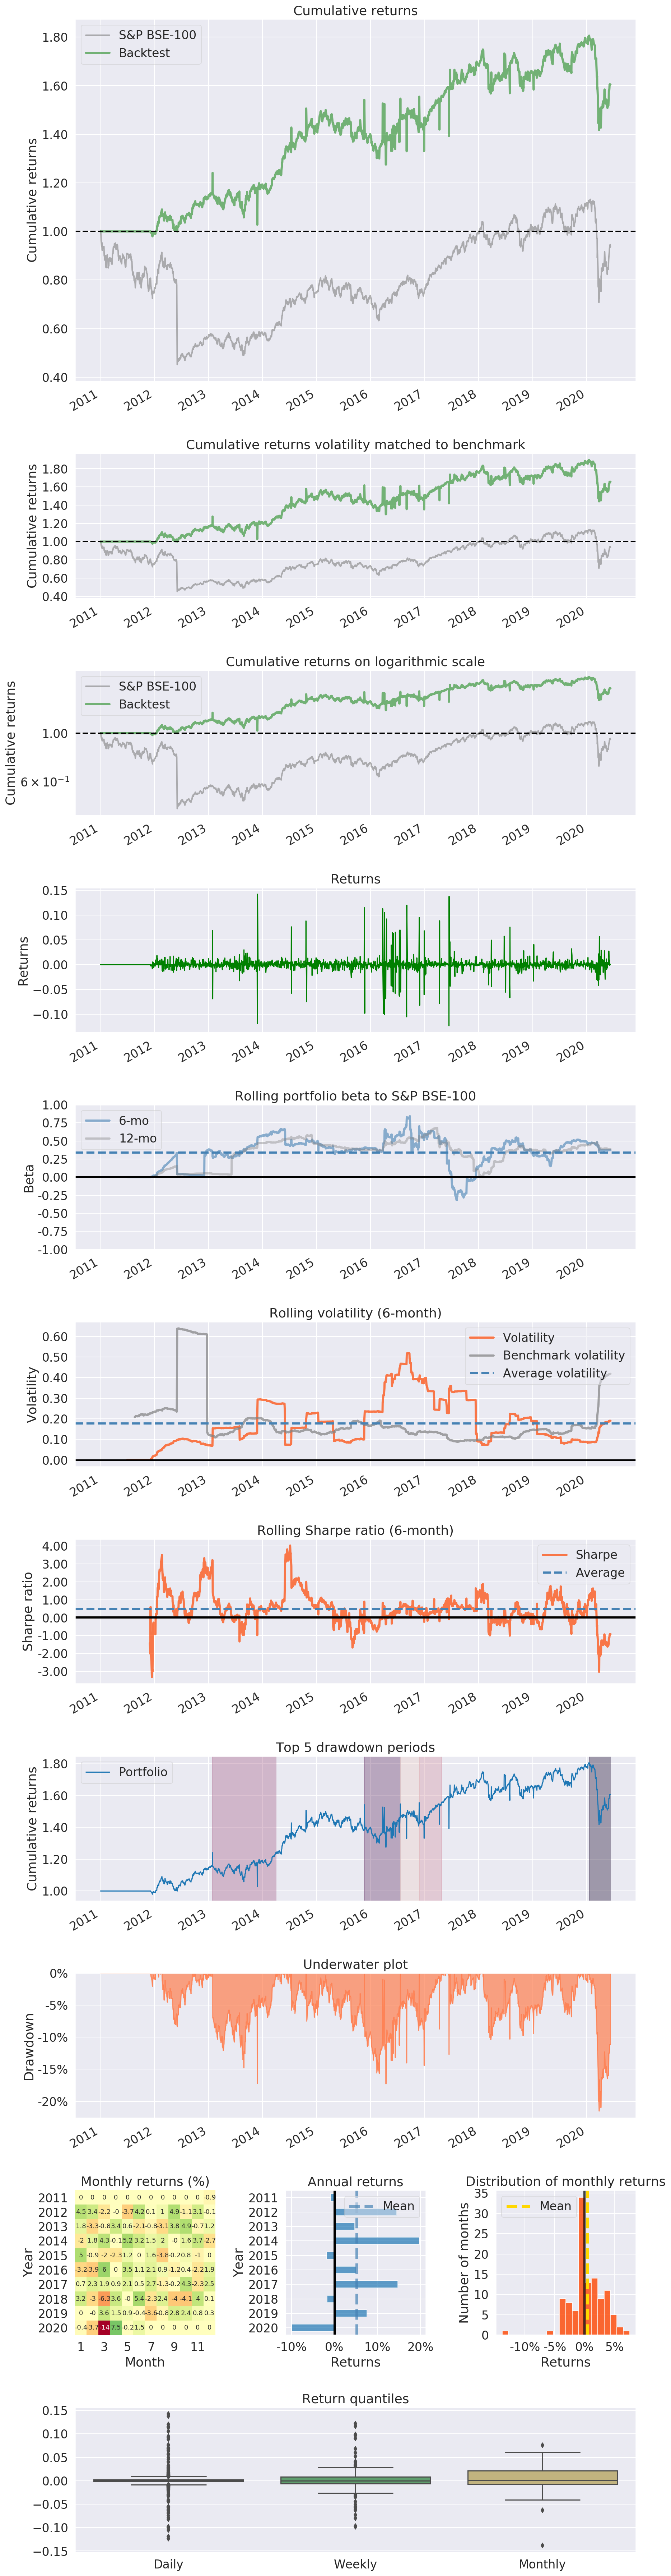

In [22]:
# generate performance stats with pyfolio
fig = pf.create_returns_tear_sheet(returns, benchmark_rets=benchmark_rets, positions=positions, transactions=transactions)
plt.savefig('chart3', dpi=800)

In [23]:
# benchmark - S&P BSE-100 performace stats
pf.show_perf_stats(benchmark_rets)

Start date,2011-01-03
End date,2020-06-09
Total months,101
,Backtest
Annual return,-0.8%
Cumulative returns,-6.4%
Annual volatility,23.3%
Sharpe ratio,0.10
Calmar ratio,-0.01
Stability,0.45
Max drawdown,-55.0%
